# Gun Violence Capstone Project

# Exploratory Data Analysis

The goal of this notebook is to explore the gun violence data and to tell a story along the way. 

**0. Begin by importing relevant packages and data wrangling code.**

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.plotly as py
from plotly.offline  import download_plotlyjs,init_notebook_mode,plot, iplot
import cufflinks as cf
import plotly.graph_objs as go
init_notebook_mode(connected = True)
from datetime import datetime
cf.go_offline()

In [2]:
df = pd.read_csv('Downloads/Data/gun-violence-data_01-2013_03-2018.csv', parse_dates=['date'])
df.drop(['incident_id','incident_url','source_url','incident_url_fields_missing','location_description','notes','participant_name','participant_relationship', 'sources', 'participant_status', 'address', 'latitude', 'longitude','participant_type','participant_age', 'gun_stolen', 'n_guns_involved'], axis = 1, inplace = True)
df.dropna(how = 'any', subset = ['incident_characteristics', 'state_house_district', 'congressional_district', 'state_senate_district'], inplace = True)
df['participant_age_group'].fillna('0::Unknown', inplace = True)
def agegroup_cleanup(row):
    agegroup_row_values = []
    agegroup_row = str(row).split("||")
    for x in agegroup_row :
        agegroup_row_value = str(x).split("::")
        if len(agegroup_row_value) > 1 :
            agegroup_row_values.append(agegroup_row_value[1])
    return agegroup_row_values
agegroupvalues = df.participant_age_group.apply(agegroup_cleanup)
df["agegroup_child"] = agegroupvalues.apply(lambda x: x.count("Child 0-11"))
df["agegroup_teen"] = agegroupvalues.apply(lambda x: x.count("Teen 12-17"))
df["agegroup_adult"] = agegroupvalues.apply(lambda x: x.count("Adult 18+"))
df = df[df['incident_characteristics'].str.contains('Non-Shooting Incident') == False]
df['date'] = pd.to_datetime(df.date)
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['monthday'] = df.date.dt.day
df['weekday'] = df.date.dt.weekday
city_list = df['city_or_county'].value_counts().head(15).index.tolist()
df = df[df['city_or_county'].apply(lambda x: x in city_list)]
df['participant_gender'].fillna('0::Unknown', inplace = True)
def gender_cleanup(row):
    gender_row_values = []
    gender_row = str(row).split("||")
    for x in gender_row :
        gender_row_value = str(x).split("::")
        if len(gender_row_value) > 1 :
            gender_row_values.append(gender_row_value[1])   
    return gender_row_values
participant_genders = df.participant_gender.apply(gender_cleanup)
df["participant_gender_total"] = participant_genders.apply(lambda x: len(x))
df["participant_gender_male"] = participant_genders.apply(lambda x: x.count("Male"))
df["participant_gender_female"] = participant_genders.apply(lambda x: x.count("Female"))
df["participant_gender_unknown"] = participant_genders.apply(lambda x: x.count("Unknown"))
big_text = "||".join(df['incident_characteristics']).split("||")
df['gun_type'].fillna('0::Unknown', inplace = True)
gt = df.groupby(by=['gun_type']).agg({'n_killed': 'sum', 'n_injured' : 'sum', 'state' : 'count'}).reset_index().rename(columns={'state':'count'})
results = {}
for i, each in gt.iterrows():
    wrds = each['gun_type'].split("||")
    for wrd in wrds:
        if "Unknown" in wrd:
            continue
        wrd = wrd.replace("::",":").replace("|1","")
        gtype = wrd.split(":")[1]
        if gtype not in results: 
            results[gtype] = {'killed' : 0, 'injured' : 0, 'used' : 0}
        results[gtype]['killed'] += each['n_killed']
        results[gtype]['injured'] +=  each['n_injured']
        results[gtype]['used'] +=  each['count']
gun_names = list(results.keys())
used = [each['used'] for each in list(results.values())]
killed = [each['killed'] for each in list(results.values())]
injured = [each['injured'] for each in list(results.values())]
incident_dict = {}
incident_dict2 = {}
for i, x in df['incident_characteristics'].iteritems():
    x = x.split('|')
    incident_dict[i] = x[0]
    if len(x)>1:
        if x[1] == '':
            incident_dict2[i] = x[2]
        else:
            incident_dict2[i] = x[1]
df2 = pd.DataFrame([incident_dict, incident_dict2])
df2 = df2.transpose()
df2 = pd.concat([df, df2], axis = 'columns')
df2.rename(columns={0:'primary_characteristic', 1: 'secondary_characteristic'}, inplace=True)

** 1. Number of Casualties **

Let's begin by observing a histogram of the number of people killed and injured per incident to see their distributions. 

In [3]:
np.arange(5000,30000,5000)

array([ 5000, 10000, 15000, 20000, 25000])

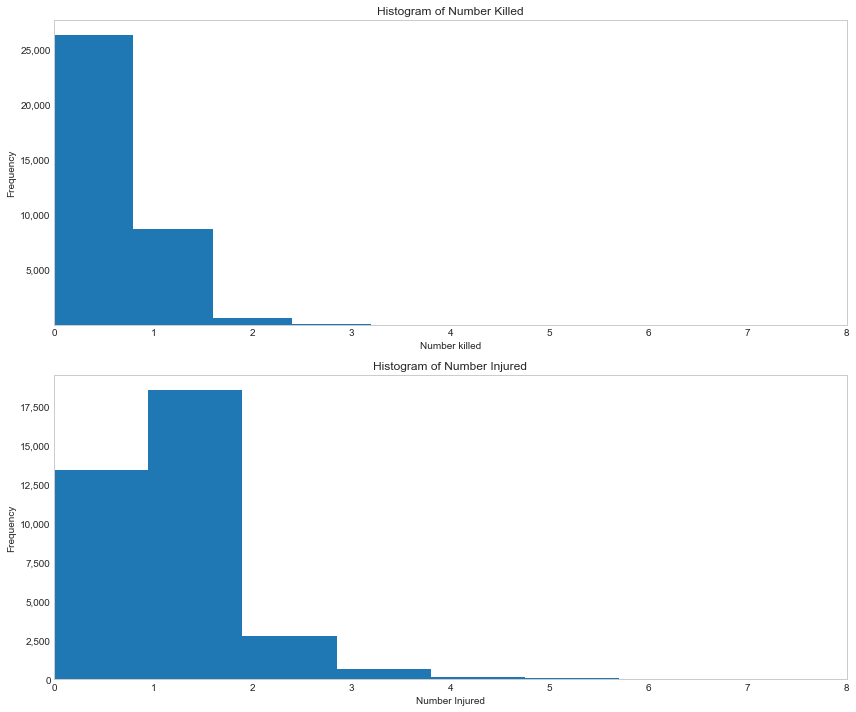

In [4]:
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize = (12,10))
_ = plt.subplot(2,1,1)
_ = plt.hist(df['n_killed'], bins=10)
_ = plt.xlabel('Number killed')
_ = plt.ylabel('Frequency')
_ = plt.yticks(np.arange(5000,30000,5000),('5,000','10,000','15,000','20,000','25,000'))
_ = plt.xlim(0,8)
_ = plt.title('Histogram of Number Killed')

_ = plt.subplot(2,1,2)
_ = plt.hist(df['n_injured'], bins=20)
_ = plt.xlabel('Number Injured')
_ = plt.ylabel('Frequency')
_ = plt.yticks(np.arange(0,20000,2500),('0','2,500','5,000','7,500','10,000','12,500','15,000','17,500'))
_ = plt.xlim(0,8)
_ = plt.title('Histogram of Number Injured')

_ = plt.tight_layout()

- Unsurprisingly, the vast majority of incidents had either 1 or no deceased victims. 

- In regards to injuries, the largest bin had between 1 and 2 injuries which means that more often than not, incidents resulted in at least 1 injury.

- Let's take a look at the boxplots.

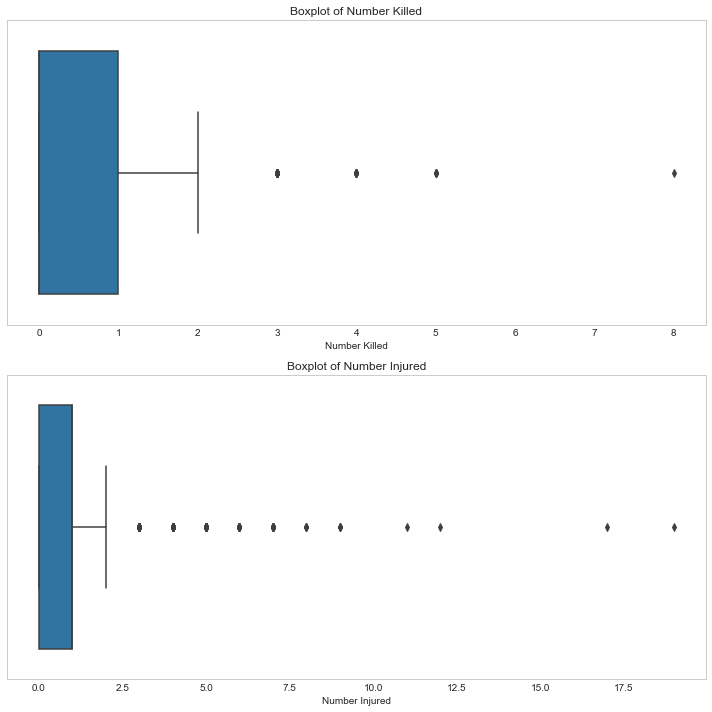

In [5]:
fig = plt.figure(figsize = (10,10))
_ = plt.subplot(2,1,1)
_ = sns.boxplot(df['n_killed'])
_ = plt.xlabel('Number Killed')
_ = plt.title('Boxplot of Number Killed')

_ = plt.subplot(2,1,2)
_ = sns.boxplot(df['n_injured'])
_ = plt.xlabel('Number Injured')
_ = plt.title('Boxplot of Number Injured')

_ = plt.tight_layout()

- The data for both the number killed and number injured is so skewed towards 0 that the 50th percentile is on 0 itself. Not to mention, it's most likely the case that the 99th percentile is also on the whiskers for each boxplot.

- Let's take a look at a stacked bar chart of the same data.

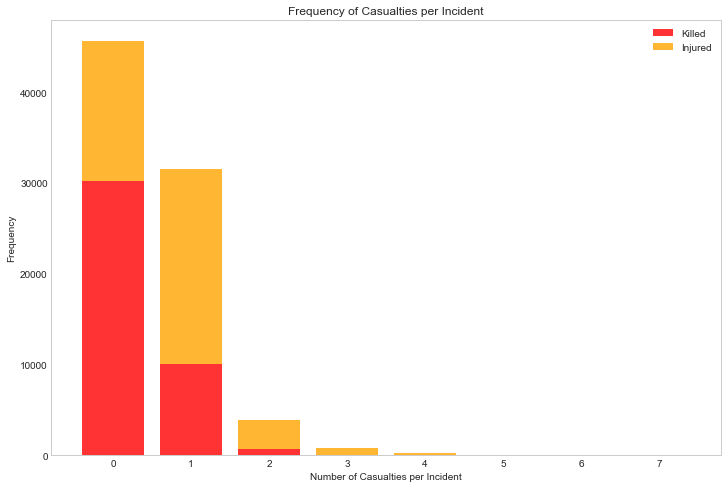

In [6]:
plt.figure(figsize = (12,8))
index = np.arange(8)
killed_list = [30236, 10063, 656, 75, 11, 3, 0, 0]
injured_list = [15403, 21431, 3183, 715, 195, 73, 18, 14]
bar_width = 0.35
opacity = 0.8

bar1 = plt.bar(x = index, height = killed_list, alpha = opacity, label = 'Killed', color = 'red')
bar2 = plt.bar(x = index , height = injured_list, alpha = opacity, bottom=killed_list, label = 'Injured', color = 'orange')

plt.xticks(np.arange(8))
plt.xlabel('Number of Casualties per Incident')
plt.ylabel('Frequency')
plt.title('Frequency of Casualties per Incident')
plt.legend()
plt.show()

- Fortunately, the majority of shooting incidents don't result in many casualties for the major cities. While there are always outliers (mass shootings), it is evident that most shootings do not result in piles of bodies.
- Comparing the number of people killed against the number of people injured can also provide valuable information. Let's use a heatmap to compare the 2 variables.

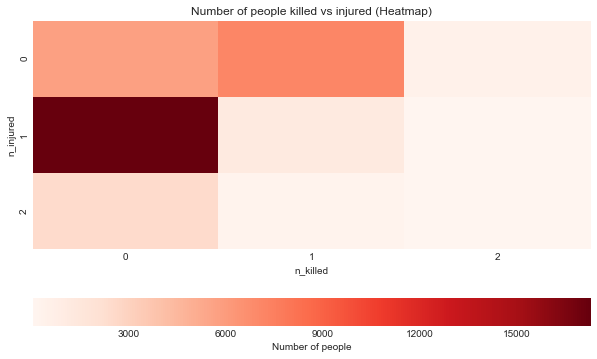

In [7]:
# Use a pandas crosstab to compare the number of people killed vs the number of people injured
# Focus on just incidents where the number of injured/killed are less than 3 since there are so few of them
x = pd.crosstab(df[df['n_injured']<3]['n_injured'], df[df['n_killed']<3]['n_killed'])
# Create the heatmap with the crosstab as the argument
plt.figure(figsize = (10,6))
sns.heatmap(x, cmap="Reds", cbar_kws={'label': 'Number of people', "orientation": "horizontal"})
plt.title('Number of people killed vs injured (Heatmap)')
plt.show()

- Based on our previous findings, it's no surprise that combinations with fewer casualties are the most common. Still, it demonstrates how most shootings do not result in a great amount of casualties. The most common combination is when there is 1 person injured and no death. This is more frequent than having no deaths or injuries at all.
- What happens when we use a scatter plot and adjust for their frequency?

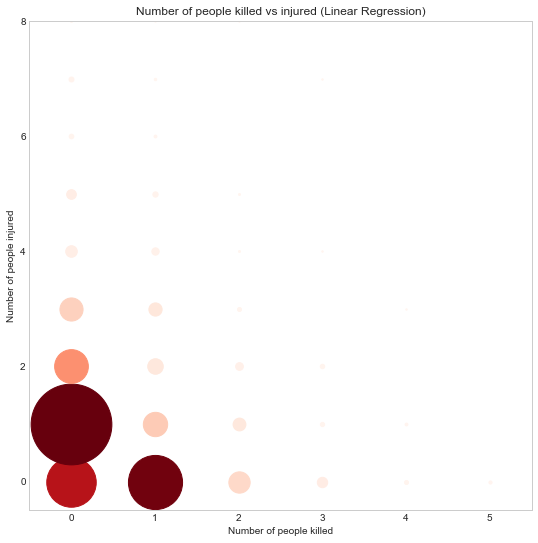

In [8]:
# Create a list that contains tuples for every combination. Each tuple has the number of injured, number of killed and frequency
scatter_list = []
for x in list(set(df['n_killed'])):
        for y in list(set(df['n_injured'])):
            scatter_list.append((x,y,len(df[(df['n_killed']==x) & (df['n_injured'] == y)])))
            
# Plot each individual combination while specifying their size as the frequency.
_ = plt.figure(figsize = (9,9))
for x in scatter_list:
# Since some combinations are much more common than others, we will have to adjust the size so that it doesn't make all the 
# other points look miniscule in comparison
    if x[2] > 1000:
        _ = plt.scatter(x[0], x[1], x[2] ** 0.9, c = x[2] ** 0.9, cmap = 'Reds', vmin=0, vmax=3000) 
    elif x[2] > 100:
        _ = plt.scatter(x[0], x[1], x[2] ** 1, c = x[2] ** 1, cmap = 'Reds', vmin=0, vmax=3000) 
    else:
        _ = plt.scatter(x[0], x[1], x[2] * 2, c = x[2] * 2, cmap = 'Reds', vmin=0, vmax=2000)

#color_bar = plt.colorbar(orientation = 'horizontal')
#color_bar.set_label('Intensity Scale')

plt.yticks([0,2,4,6,8,10,12,14,16,18,20])
plt.xlim(-0.5, 5.5)
plt.ylim(-0.5, 8)
plt.xlabel('Number of people killed')
plt.ylabel('Number of people injured')
plt.title('Number of people killed vs injured (Linear Regression)')
plt.show()

- First thing to notice is that the only incidents with less than 2 killed and less than 3 injured are clearly visible. The color scheme scales with the frequency of the combinations occuring, which shows that the vast majority of incidents have occured with these few combinations. 
- Another point is that there are very few outliers that are visible (not transparent). In fact, it's very difficult to see points where there are more than 3 peopled killed or more than 4 people injured. This further proves the previous point that incidents with multiple casualties are very rare.

**2. Casualties by City**

First let's see the total number of incidents per city.

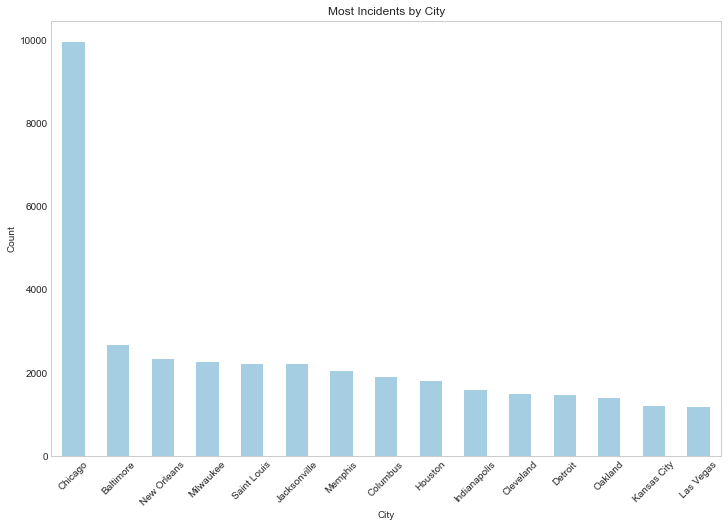

In [9]:
plt.figure(figsize=(12,8))

df['city_or_county'].value_counts().head(15).plot(kind='bar', cmap = 'Paired')

plt.xlabel('City')
plt.xticks(rotation = 45)
plt.ylabel('Count')
plt.title('Most Incidents by City')
plt.show()

- Chicago is overwhelmingly the most violent city in terms of incidents with Baltimore and Philadelphia trailing at second and third, respectively. There is a big drop-off after Chicago which implies that it is an obvious outlier as a city but should still be included.

- How about in terms of deaths and injuries?

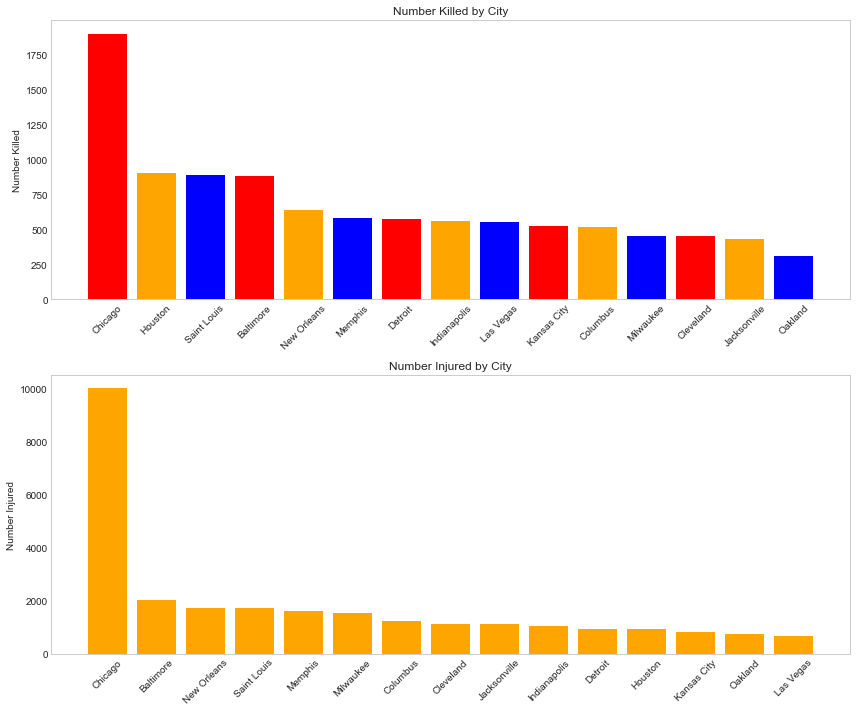

In [10]:
city_victims = df.groupby('city_or_county')['n_killed', 'n_injured'].sum().sort_values('n_killed',ascending = False).head(15)
city_victims1 = df.groupby('city_or_county')['n_killed', 'n_injured'].sum().sort_values('n_injured',ascending = False).head(15)

list_killed = []
for x in city_victims.values:
    list_killed.append(x[0])

list_injured = []
for x in city_victims1.values:
    list_injured.append(x[1])
    
list_cities = city_victims.index.tolist()
list_cities1 = city_victims1.index.tolist()
    
fig = plt.figure(figsize = (12,10))

_ = plt.subplot(2,1,1)
_ = plt.bar(x = list_cities, height=list_killed, color = ['red','orange', 'blue'])
_ = plt.xticks(rotation = 45)
_ = plt.ylabel('Number Killed')
_ = plt.title('Number Killed by City')

_ = plt.subplot(2,1,2)
_ = plt.bar(x = list_cities1, height = list_injured, color ='orange')
_ = plt.xticks(rotation = 45)
_ = plt.ylabel('Number Injured')
_ = plt.title('Number Injured by City')

_ = plt.tight_layout()

In [11]:
city_victims.iplot(
    kind="bar", 
    barmode='stack', 
    xTitle='City', 
    yTitle='Number of Casualties', 
    title='Casualties for the Top 15 Most Violent Cities',
    showgrid=False
)

- Once again, Chicago tops the list with the most killed and injured in shooting incidents. However, what is interesting to note here is the fact that while Houston has the 2nd most number of killed, it does not have the 2nd most casualties among the top 15 cities. In fact, it is not even among the top 5 and this is due to the fact that other cities such as Baltimore and Philadelphia have many more injuries. 

- Out of curiosity, let's observe the data when we remove Chicago from the list of cities.

In [12]:
city_victims.drop('Chicago').iplot(
    kind="bar", 
    barmode='stack', 
    xTitle='City', 
    yTitle='Number of Casualties', 
    title='Casualties for the Top 14 Most Violent Cities (excluding Chicago)',
    showgrid=False
)

- Without Chicago, the difference in the number of deaths between the cities has been leveled and the number of injuries has become much more prominent in deciding which of these cities is the most violent. As observed in the previous plot, Baltimore is the 2nd highest in terms of casualties (2911 victims) and it has double the number of casualties as either Las Vegas (1228) or Oakland (1066).
- Now let's take a look at the number of deaths per year and month.

**3. Casualties by Date**

Let's start with a simple heatmap to observe any potential relationships between the dates and the number of casualties.

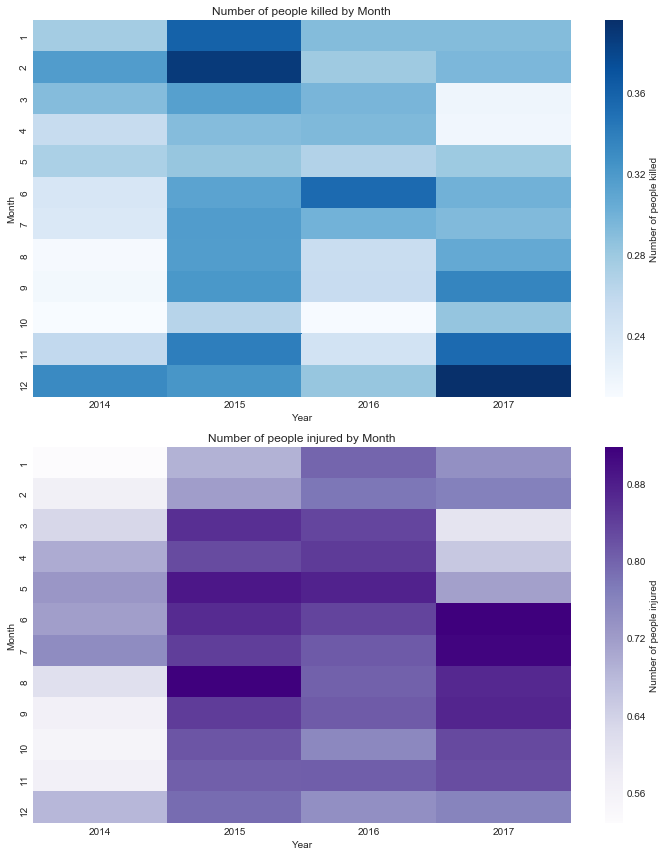

In [13]:
heat_k = df.pivot_table('n_killed','month','year').drop([2013,2018], axis=1)
plt.figure(figsize = (10,12))
plt.subplot(2,1,1)
sns.heatmap(heat_k, cmap = 'Blues', cbar_kws={'label': 'Number of people killed'})
plt.xlabel('Year')
plt.ylabel('Month')
plt.title('Number of people killed by Month')

heat_i = df.pivot_table('n_injured','month','year').drop([2013,2018], axis=1)
plt.subplot(2,1,2)
sns.heatmap(heat_i, cmap = 'Purples', cbar_kws={'label': 'Number of people injured'})
plt.xlabel('Year')
plt.ylabel('Month')
plt.title('Number of people injured by Month')

plt.tight_layout()

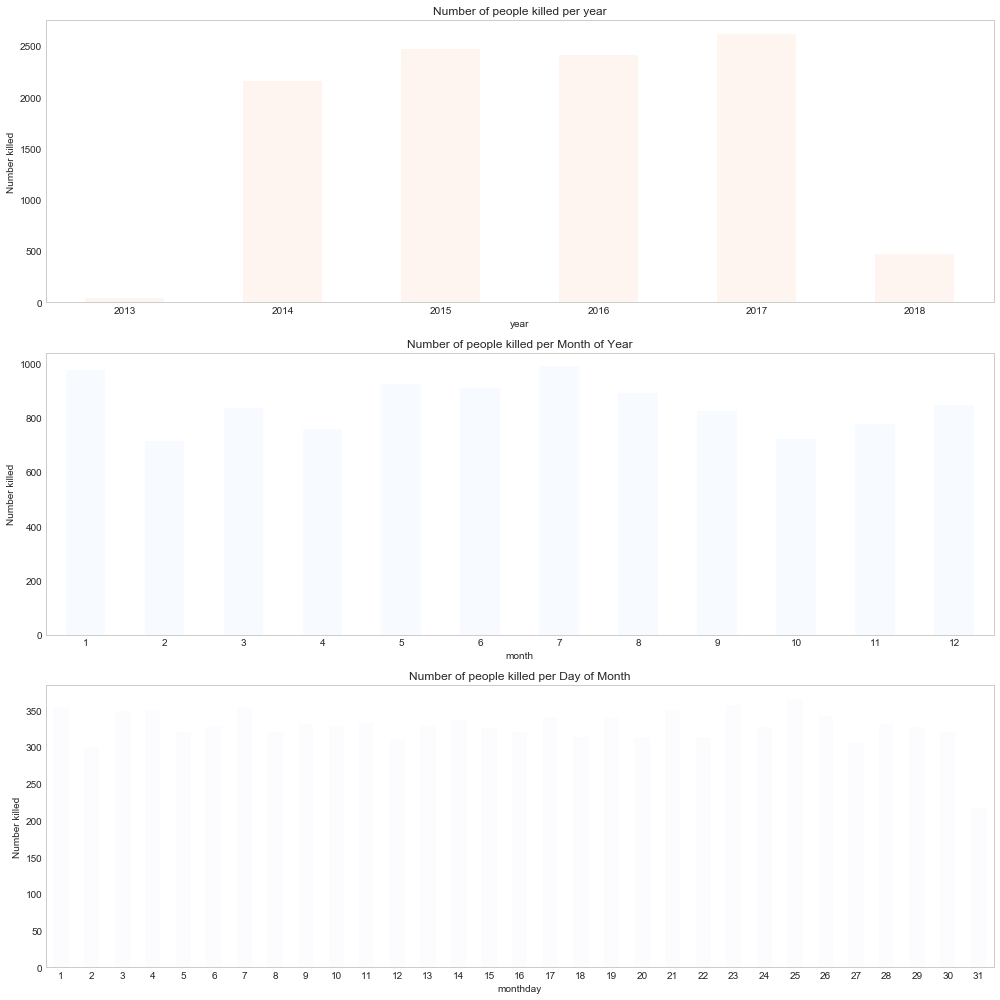

In [14]:
# Creating a bar chart of the number of people killed per year in the top 15 most violent cities
fig  = plt.figure(figsize = (14,14))

_ = plt.subplot(3,1,1)
_ = df.groupby('year')['n_killed'].sum().plot(kind='bar', cmap = 'Reds')
_ = plt.xticks(rotation = 0)
_ = plt.ylabel('Number killed')
_ = plt.title('Number of people killed per year')

_ = plt.subplot(3,1,2)
_ = df.groupby('month')['n_killed'].sum().plot(kind='bar', cmap = 'Blues')
_ = plt.xticks(rotation = 0)
_ = plt.ylabel('Number killed')
_ = plt.title('Number of people killed per Month of Year')

_ = plt.subplot(3,1,3)
_ = df.groupby('monthday')['n_killed'].sum().plot(kind='bar', cmap = 'Purples')
_ = plt.xticks(rotation = 0)
_ = plt.ylabel('Number killed')
_ = plt.title('Number of people killed per Day of Month')

_ = plt.tight_layout()

- It is very clear that the number of people killed has been growing over the last 4 years. Surprisingly, 2016 had about the same number of shooting deaths than 2015 in the 15 major cities despite the overall number of deaths growing in all cities. The distribution of killed is about equally distributed among the months (besides February and April) as well as the days (besides the 31st since it does not occur on every month).

- (Note: 2013 is significantly lower due to lack of data from that year while 2018 is lower due to the end date of the dataset being 3/31/18.) 

- To get a better picture of what the distribution of casualties is, let's take a look at the number of casualties for the years 2014 through 2017.

In [15]:
pd.crosstab(df['year'],df['n_killed']).iloc[1:5,1:].iplot(
    kind='bar', 
    xTitle = 'Year', 
    yTitle = 'Number of Deaths', 
    title = 'Number of Deaths per year',
    showgrid=False
)

- There was a huge increase in the number of deaths from 2014 to 2015 in incidents with only 1 death but also in incidents with multiple deaths. 
- In general, the number of incidents with only 1 death has been going up each year, whereas the number of incidents with multiple deaths (at least 2) seems to fluctuate based on the year.
- Now let's take a look at a time series for each year from 2014-2018 to see the progression of casualties throughout the year.

In [16]:
# Credit: https://www.kaggle.com/bhaveshthaker/gvd-data-prep-feature-eng-exploratory-analysis
# Time Series plot for 2014
temp = df[df['year'] == 2014].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})
trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350, title = 'Gun Violence Incidents - 2014', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)

# Time Series plot for 2015
temp = df[df['year'] == 2015].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})
trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350, title = 'Gun Violence Incidents - 2015', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)

# Time Series plot for 2016
temp = df[df['year'] == 2016].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})
trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350, title = 'Gun Violence Incidents - 2016', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)

# Time Series plot for 2017
temp = df[df['year'] == 2017].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})
trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350, title = 'Gun Violence Incidents - 2017', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)

# Time Series plot for 2018
temp = df[df['year'] == 2018].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})
trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350, title = 'Gun Violence Incidents - 2018', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)

- A pattern that occurs for all the years is that the number of casualties starts slower in the first 3 months but begins to pick up in the summer months (2017 appears to be more evenly distributed however).

**4. Incidents by Gender**

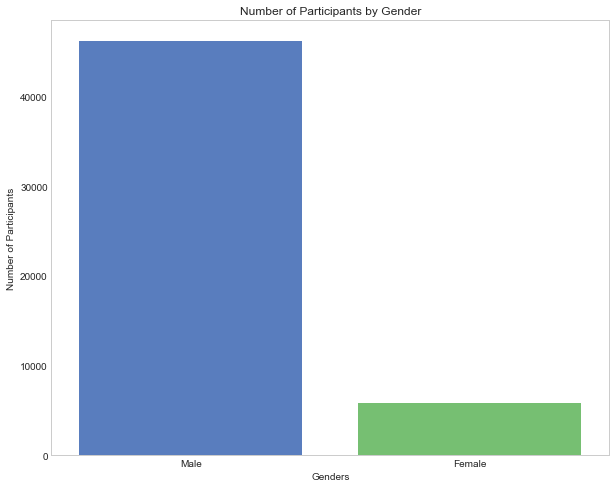

In [17]:
female_count = np.sum(df['participant_gender_female'].values)
male_count = np.sum(df['participant_gender_male'].values)
gender_dict = {'Gender': ['Female', 'Male'], 'Count': [female_count, male_count]}
gender_df = pd.DataFrame(gender_dict)

fig = plt.figure(figsize = (10,8))
_ = sns.barplot(x='Gender', y = 'Count', data=gender_df, order=['Male', 'Female'], palette="muted")
_ = plt.xlabel('Genders')
_ = plt.ylabel('Number of Participants')
_ = plt.title('Number of Participants by Gender')
_ = plt.show()

It is very clear that there are many more male participants than female participants in shooting incidents. This could be due to a number of factors such as the fact that shooters are predominantly male but there could also be a psychological bias against males.

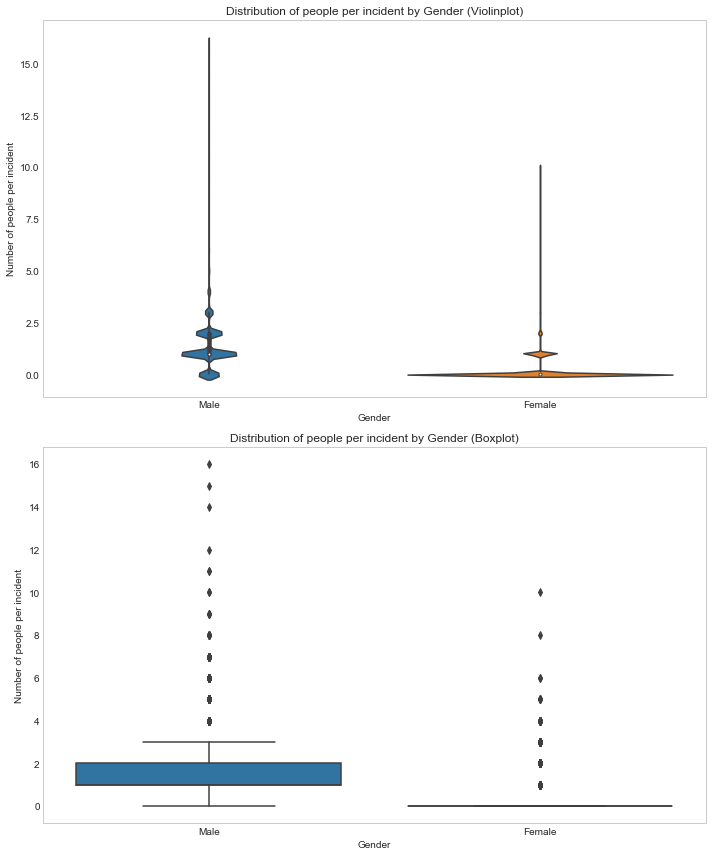

In [18]:
genders = df[['participant_gender_male', 'participant_gender_female']]

fig = plt.figure(figsize = (10,12))
_ = plt.subplot(2,1,1)
_ = sns.violinplot(data=genders)
_ = plt.xlabel('Gender')
_ = plt.xticks(range(2), ['Male', 'Female'])
_ = plt.ylabel('Number of people per incident')
_ = plt.title('Distribution of people per incident by Gender (Violinplot)')

_ = plt.subplot(2,1,2)
sns.boxplot(data = genders)
_ = plt.xlabel('Gender')
_ = plt.xticks(range(2), ['Male', 'Female'])
_ = plt.ylabel('Number of people per incident')
_ = plt.title('Distribution of people per incident by Gender (Boxplot)')

_ = plt.tight_layout()

- The boxplot indicates that on average, there's at least 1 male involved in every incident (whether as a victim or victim). 

- On the other hand, there are so few females that it skews the percentiles to nearly 0. This is further supported by the violin plot where only a small fraction of incidents has females involved. 

- Let's take a look at a scatter plot comparing the number of males vs number of females per incident.

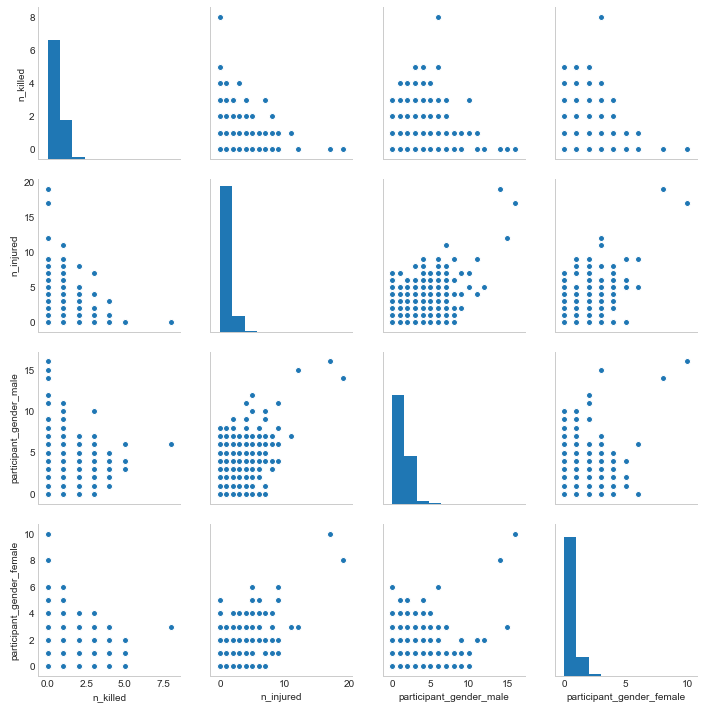

In [19]:
sns.pairplot(df[['n_killed','n_injured','participant_gender_male','participant_gender_female']])

(-0.5, 10.5)

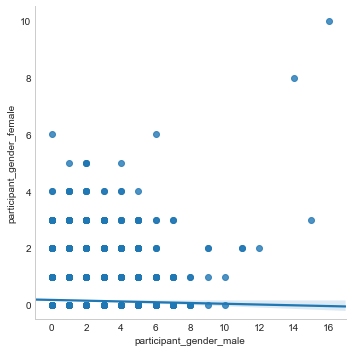

In [20]:
sns.lmplot('participant_gender_male','participant_gender_female', data=df)
plt.ylim(-0.5, 10.5)

- Just by taking a quick look at the regression plot, we can already tell how much the data is skewed towards the male participants. It almost looks like the regression line is the horizontal axis itself due to the fact that the y-intercept is very close to the origin while the x-intercept is near the outlier values.

**5. Casualties by Incident Characteristics**

To get a visual feel for the incident characteristics, let's create a word cloud and see which are the most common words or phrases.

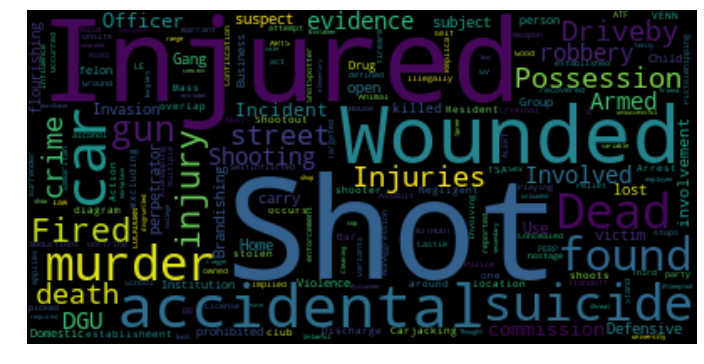

In [21]:
import nltk
from wordcloud import WordCloud

# Join the incident characteristics from the list into a single string
text = ' '.join(big_text)
text = text.replace('-','').replace('/',' ')
# Generate the wordcloud with collocations = False to remove duplicate words
basecloud = WordCloud(collocations=False).generate(text)
# Create a function that will generate the wordcloud
def plot_wordcloud(wordcloud):
    plt.figure(figsize = (12,12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
plot_wordcloud(basecloud)

- It looks like the most common words are Injured, Wounded, Shot and accidental, which makes sense considering all of these are characteristics from shooting incidents.

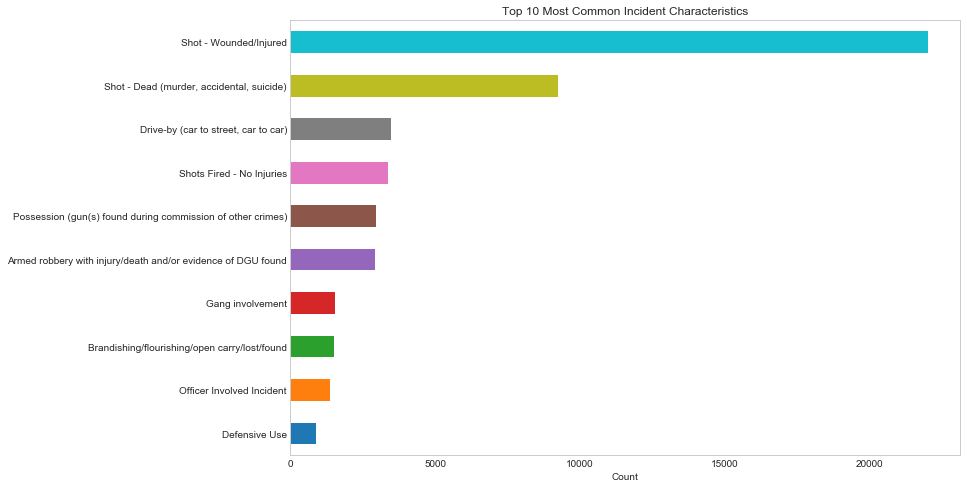

In [22]:
_ = plt.figure(figsize = (12,8))
_ = pd.Series(big_text).value_counts().head(10).sort_values(ascending=True).plot(kind = 'barh')
_ = plt.xlabel('Count')
_ = plt.title('Top 10 Most Common Incident Characteristics')

- The most common incident characteristic is 'Shot-Wounded/Injured' as it has over 25,000 mentions and this is not a surprise since most shootings have resulted in an injury. The second most common incident is 'Shot - Dead (murder, accidental, suicide)' and the third is 'Shots Fired - No Injuries'. It seems that the rest of the characteristics are secondary and add on to the first 3.

- Now let's look at the most common primary/secondary incident characteristics by number killed and number injured.

In [23]:
incident_df_killed = df2.groupby('primary_characteristic')['n_killed', 'n_injured'].sum().sort_values('n_injured',ascending=False).head(10)
incident_df_killed.iplot(
    barmode='stack',
    kind="bar", 
    xTitle='Incident Characteristic', 
    yTitle='Number of Casualties', 
    title='Number of Casualties by Primary Incident Characteristics',
    showgrid=False
)

incident_df_killed = df2.groupby('secondary_characteristic')['n_killed', 'n_injured'].sum().sort_values('n_injured',ascending=False).head(10)
incident_df_killed.iplot(
    barmode = 'stack',
    kind="bar", 
    xTitle='Incident Characteristic', 
    yTitle='Number of Casualties', 
    title='Number Injured by Secondary Incident Characteristics',
    showgrid=False
)

- Not surprisingly, the most common primary incident for incidents with at least 1 dead victim is 'Shot - Dead' whereas its counterpart for incidents with at least 1 injured victim is 'Shot - Wounded/Injured'. 

- There is a big drop off after the first 2 primary characteristics. The most common secondary characteristic is 'Shot-dead', which makes sense since there are many incidents which have both a death and an injury. The 2nd most common characteristic is 'Drive-by' and then it begins to flatten out.

**6. Casualties by Gun Type**

Let's create another wordcloud for the gun types to visually see the most common gun types.

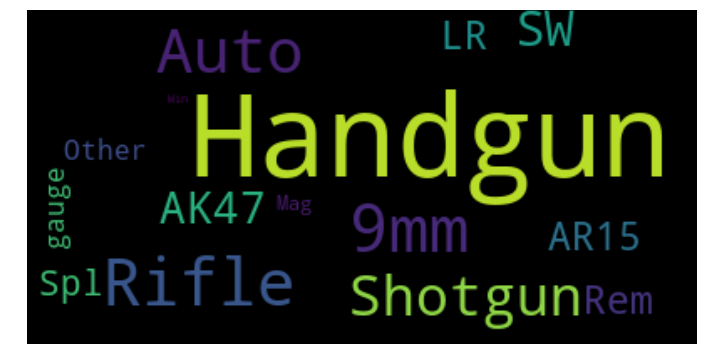

In [24]:
# Create a string with the gun types
g_text = "||".join(df['gun_type']).split("||")
gun_text = ' '.join(g_text)
gun_text = gun_text.replace('-','').replace('/',' ')
# Create the wordcloud by specifying no duplicates and to not include 'Unknown' in the wordcloud
guncloud = WordCloud(collocations=False, stopwords = {'Unknown'}).generate(gun_text)
plot_wordcloud(guncloud)

- The most popular gun type that comes up are handguns while the other gun types like Shotgun and Rifles also seem relatively popular. 

In [25]:
gun = pd.DataFrame({'Gun name' : gun_names, 'Used': used})
gun.groupby('Gun name').sum().sort_values(by='Used', ascending=False).head(10).iplot(
    kind='bar', xTitle = "Gun Name", yTitle = "Count", title = "Most used Guns", color = 'pink', showgrid=False)

gun_df = pd.DataFrame({'Gun name' : gun_names,'Injured': injured, 'Killed': killed})
gun_df.groupby('Gun name').sum().sort_values(by='Killed', ascending=False).head(10).iplot(
    kind='bar', xTitle = "Gun Name", yTitle = "Count", title = "Number of Casualties by Gun Type", barmode = 'stack',showgrid=False)

- The most popular handgun used in shooting incidents has been the handgun for the last 5 years. This can be attributed to a multitude of factors such as the fact that it's more accesible, cheaper, and lighter than rifles. It is most likely the case that other types of firearms have been used in mass shootings.

**7. Casualties by Congressional District**

In [26]:
cong = df['congressional_district'].value_counts().head(15)

trace0 = go.Bar(
    x = ['d'+str(ele) for ele in cong.index], 
    y = cong.values,
    name = 'Number of Peopled Killed'
)

data = [trace0]
layout = go.Layout(
    
    title = 'Number of Incidents by Congressional District', 
    xaxis= dict(title='Congressional District', ticklen=1, showgrid=False),
    yaxis = dict(title = 'Number of Incidents', ticklen = 1, showgrid=False),
    

)
fig = go.Figure(data = data,layout = layout)
iplot(fig)

- Congressional District 7 has nearly 8000 different incidents while district 1 has 5551 and district 4 has 4594. Could there be a relationship between cong. district 7 and Chicago?
- After district 3, the number of incidents seems to fall off. Most likely due to lack of cities in the data.

In [27]:
cong_k = df.groupby('congressional_district', as_index=False)['n_killed'].sum().sort_values(by='n_killed', ascending=False).head(15)
cong_i = df.groupby('congressional_district', as_index=False)['n_injured'].sum().sort_values(by='n_injured', ascending=False).head(15)

trace0 = go.Bar(
    x = ['d'+str(ele) for ele in cong_k.congressional_district], 
    y = cong_k.n_killed,
    name = 'Number of Peopled Killed'
)
trace1 = go.Bar(
    x = ['d'+str(ele) for ele in cong_i.congressional_district], 
    y = cong_i.n_injured,
    name = 'Number of Peopled Injured'
)

data = [trace0, trace1]
layout = go.Layout(
    
    title = 'Number of Casualties by Congressional District', 
    barmode = 'stack',
    xaxis= dict(title='Congressional District', ticklen=1, showgrid=False),
    yaxis = dict(title = 'Number of Casualties', ticklen = 1, showgrid=False)

)
fig = go.Figure(data = data,layout = layout)
iplot(fig)

- Congressional district 7 is definitely the most violent district as they have over 7000 injuries and over 2100 deaths. This could be attributed to a variety of factors: location, demographic, gun laws, population, etc.
- After about district 11, the number of casualties begins to diminish quite a bit. This is most likely due to the fact that the data comes only from 15 cities in America. If given more data, there would probably be a variety of other districts with more casualties.
- Let's explore the relationship between Chicago and the congressional districts. It's possible that there is a very small correlation between them but it may be interesting to investigate.

In [28]:
# Create a Series that shows the number of n_killed and n_injured in Chicago by congressional districts 
chi_cong_k = df.groupby(['city_or_county','congressional_district'])['n_killed'].sum()['Chicago'].sort_values(ascending=False).head(15)
chi_cong_i = df.groupby(['city_or_county','congressional_district'])['n_injured'].sum()['Chicago'].sort_values(ascending=False).head(15)

trace0 = go.Bar(
    x = ['d'+str(ele) for ele in chi_cong_k.index], 
    y = chi_cong_k.values,
    name = 'Number of Peopled Killed'
)
trace1 = go.Bar(
    x = ['d'+str(ele) for ele in chi_cong_i.index], 
    y = chi_cong_i.values,
    name = 'Number of Peopled Injured'
)

data = [trace0, trace1]
layout = go.Layout(
    
    title = 'Number of Casualties by Congressional District (Chicago)', 
    barmode = 'stack',
    xaxis= dict(title='Congressional District', ticklen=1),
    yaxis = dict(title = 'Number of Casualties', ticklen = 1, showgrid=False)

)
fig = go.Figure(data = data,layout = layout)
iplot(fig)

- Our curiosity was not for naught as we can see that Chicago was the highest contributor to district 7's large amount of casualties with 4400 injuries and 815 deaths. 
- In fact, they also have quite a lot of casualties for district 1 with 2549 injuries and 464 deaths. This shows how Chicago's overwhelming influence on the casualty statistics has also affected the congressional districts. 
- Is it possible that Chicago is also responsible for the most violent state house districts? Let's find out.

**8. Casualties by State House District**

In [29]:
house = df['state_house_district'].value_counts().head(15)

trace0 = go.Bar(
    x = ['d'+str(ele) for ele in house.index], 
    y = house.values,
    name = 'Number of Peopled Killed'
)

data = [trace0]
layout = go.Layout(
    
    title = 'Number of Incidents by State House District', 
    xaxis= dict(title='State House District', ticklen=1),
    yaxis = dict(title = 'Number of Incidents', ticklen = 1, showgrid=False)

)
fig = go.Figure(data = data,layout = layout)
iplot(fig)

- District 10 has the most incidents at 2200 and district 18 has the second most at 1882. 
- After the first 2, the rest of the districts have incident numbers close to one another and the trend is a gradual decline rather than a sporadic variety.

In [30]:
house_k = df.groupby('state_house_district', as_index=False)['n_killed'].sum().sort_values(by='n_killed', ascending=False).head(15)
house_i = df.groupby('state_house_district', as_index=False)['n_injured'].sum()

# Create a list to hold all the districts that will be used in shd1
house_list=[]
for x in house_k.state_house_district:
    for y in house_i[house_i['state_house_district'] == x]['n_injured']:
        house_list.append(y)

trace0 = go.Bar(
    x = ['d'+str(ele) for ele in house_k.state_house_district], 
    y = house_k.n_killed,
    name = 'Number of Peopled Killed'
)
trace1 = go.Bar(
    x = ['d'+str(ele) for ele in house_k.state_house_district], 
    y = house_list,
    name = 'Number of Peopled Injured'
)

data = [trace0, trace1]
layout = go.Layout(
    
    title = 'Number of Casualties by State House District', 
    barmode = 'stack',
    xaxis= dict(title='State House District', ticklen=1),
    yaxis = dict(title = 'Number of Casualties', ticklen = 1, showgrid=False)

)
fig = go.Figure(data = data,layout = layout)
iplot(fig)

- The gap between state house districts 10 and 18 grows wider when looking at casualties. District 10 has over 2500 total casualties whereas district 18 has 1567. This is more than double the difference of their number of incidents. 
- While the number of deaths among the top 15 districts are similar, the variance of their injury counts is much greater. This could be attributed to the fact that most incidents have 0 or 1 deaths whereas the number of injuries casts a bigger net.

**9. Casualties by Age Group**

In [31]:
adult_count = np.sum(df['agegroup_adult'].values)
teen_count = np.sum(df['agegroup_teen'].values)
child_count = np.sum(df['agegroup_child'].values)
agegroup_dict = {'Count': [adult_count, teen_count, child_count], 'AgeGroup': ['Adult (18+)', 'Teen (12-17)', 'Child (0-12)']}
agegroup_df = pd.DataFrame(agegroup_dict)
agegroup_df.set_index('AgeGroup', inplace = True)

agegroup_df.iplot(kind='bar', xTitle = "Age Group", yTitle = "Number of Participants", 
                  title = "Number of Participants by Age Group", color = 'green', showgrid=False)

- The adult age group have the most number of participants at over 50,000 while the teen age group has 4652 and the child age group comes at less than 734. This makes sense since most non-accidental shooting incidents have shooters who don't want to harm children or teenagers. A majority of these people would rather avoid harming younger people out of guilt.

Next, let's use a pairplot to create scatterplot matrices to show the correlations between the age groups and the number of casualties.

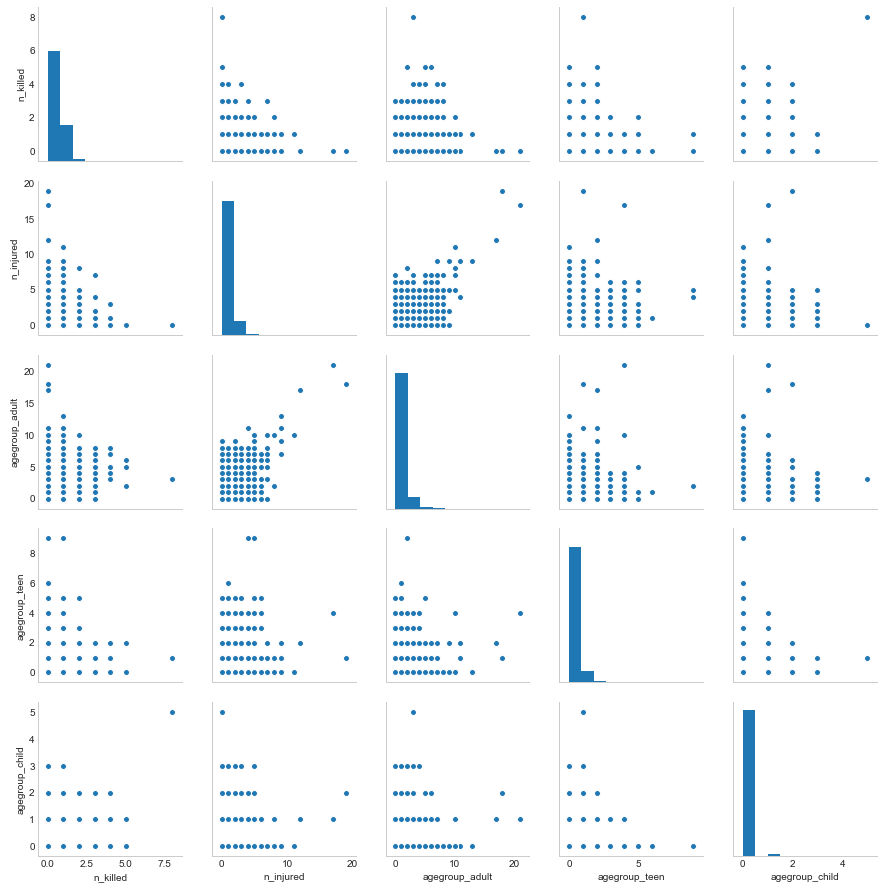

In [32]:
sns.pairplot(df[['n_killed', 'n_injured', 'agegroup_adult','agegroup_teen','agegroup_child']])

- Take a look at the last 3 plots for the n_injured and n_killed rows. 
- The adult age group feature does not appear to have a strong correlation to the number of people killed nor the number of people injured. In fact, they both have block-shapes, which indicates that there is a wide variety of different possible scenarios. One would expect that with more males, there would be more casualties but there doesn't seem to be a strong trend supporting that assumption.
- The teen and child age groups are less stacked due to the lack of incidents where teens and children are involved. However, they do show a negative correlation against number of people killed and injured. Perhaps this implies that if more underaged people are involved, shooters are less willing to harm them?